In [18]:
## Imports

# General
import os
import os.path as path
import json
from glob import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

%matplotlib inline

In [23]:
# Set data to be processed
DROOT = './0_data'

# Sources
EYE_SRC = path.join(DROOT, "2_procfootage/eyetracker")
EYE_LBL = path.join(DROOT, "2_procfootage/eyetracker/labels.csv")
RND_SRC = path.join(DROOT, "2_procfootage/360-cropped.jpg")
RND_SRC_EXERPS = path.join(DROOT, "2_procfootage/round_img/")
RND_LBL = path.join(DROOT, "2_procfootage/round_img/labels.csv")
MAP_SIM = path.join(DROOT, "4_simsiam/mapping.csv")

# Destination video
VID_DST = path.join(DROOT, "4_simsiam/video.mp4")

,true_x,true_y,base_id,base_x,base_y,pupil_pos_x,pupil_pos_y,pupil_rel_pos_x,pupil_rel_pos_y,eye_left_pos_x,eye_left_pos_y,eye_right_pos_x,eye_right_pos_y,base_id_est,base_x_est,base_y_est,final_x,final_y
frame,,,,,,,,,,,,,,,,,,
243,975,1568,165,905,1448,-0.054556,-0.041589,394,109,-0.329855,0.000763,0.167794,-0.010009,128,0,1267,394,1376
244,1106,1582,166,1086,1448,-0.063643,-0.037841,375,125,-0.335065,0.005457,0.155663,-0.006641,169,1629,1448,2004,1573
245,1017,1630,166,1086,1448,-0.060947,-0.038294,382,129,-0.332708,0.007022,0.149600,-0.005692,169,1629,1448,2011,1577


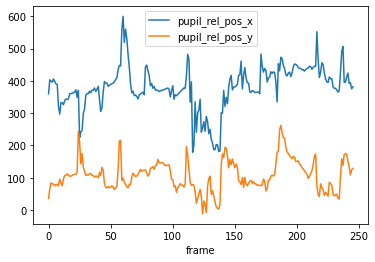

In [12]:
# Set up the positions of in-frame location
# The Y-axis is a bit confusing, but since we're dealing from with a reverse 
#  axis (lower is higher in the image), higher y means lower position.
eye_labels = pd.read_csv(EYE_LBL, index_col='frame')
eye_labels.pupil_rel_pos_x *= (720/2)
eye_labels.pupil_rel_pos_y *= (720/2)

pos_columns = ['pupil_rel_pos_x', 'pupil_rel_pos_y']
eye_labels['pupil_rel_pos_x'] += (720/2)
eye_labels[pos_columns] = eye_labels[pos_columns].astype(int)

eye_labels[pos_columns].plot()

# Get estimated location of each in base image
frameloc = pd.read_csv(MAP_SIM, index_col='frame_id')
eye_labels = eye_labels.merge(frameloc, left_index=True, right_index=True)

# Add x and y of estimated frame to transform to master image.
eye_labels['final_x'] = (eye_labels.base_x_est + eye_labels.pupil_rel_pos_x)
eye_labels['final_y'] = (eye_labels.base_y_est + eye_labels.pupil_rel_pos_y)

eye_labels.tail(3)

# Tests

<AxesSubplot:>

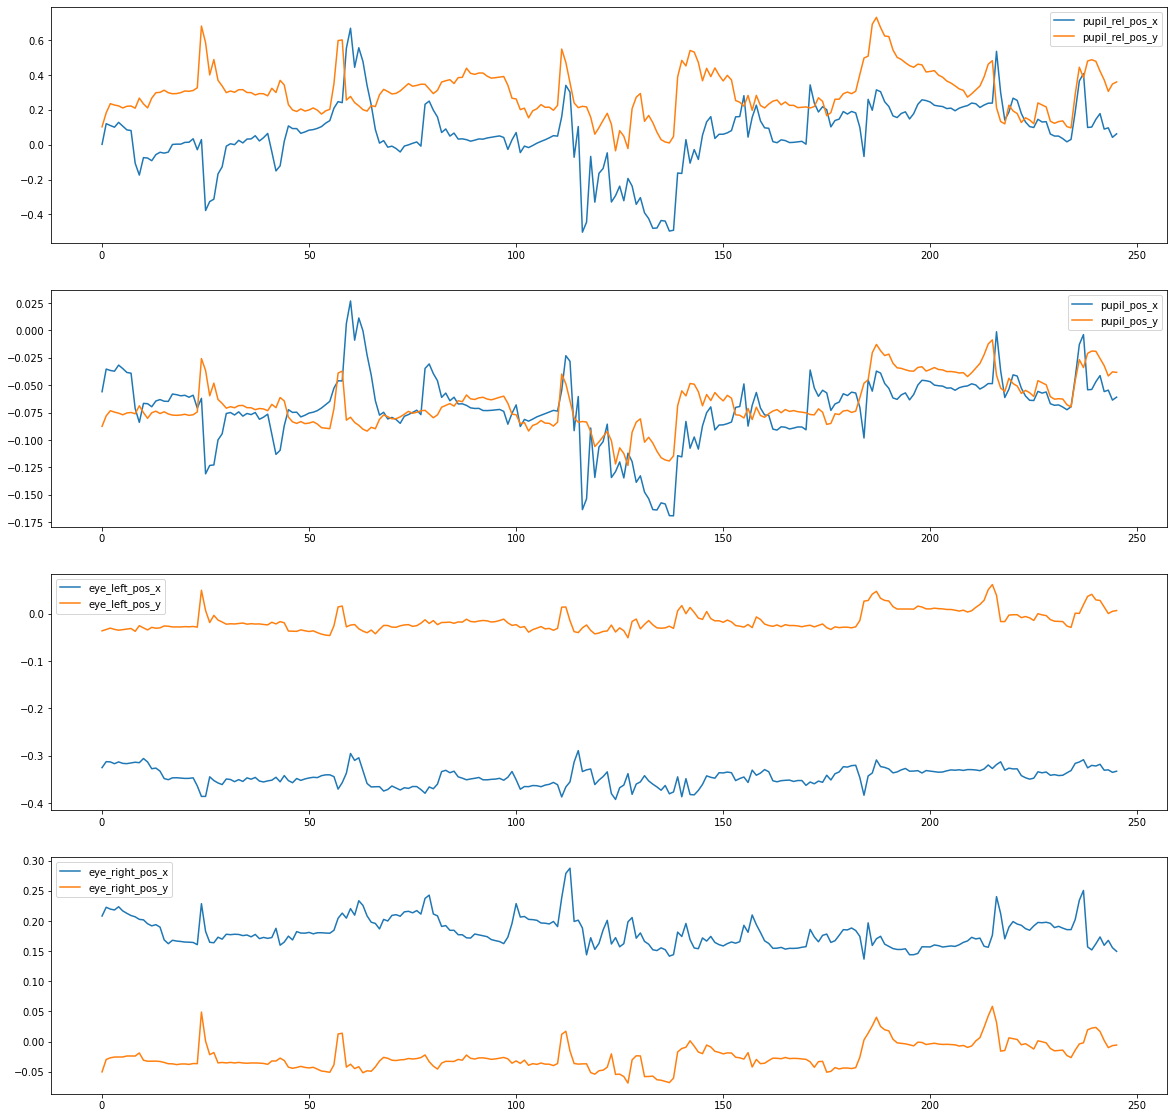

In [204]:
fig, axs = plt.subplots(nrows=4, figsize=(20, 20))
labels[['pupil_rel_pos_x', 'pupil_rel_pos_y']].plot(ax=axs[0])
labels[['pupil_pos_x', 'pupil_pos_y']].plot(ax=axs[1])
labels[['eye_left_pos_x', 'eye_left_pos_y']].plot(ax=axs[2])
labels[['eye_right_pos_x', 'eye_right_pos_y']].plot(ax=axs[3])

# Generate video

In [52]:
base = cv2.imread(RND_SRC)
height, width, layers = base.shape
print(base.shape)
r = 150

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
video = cv2.VideoWriter(VID_DST, fourcc, 10, (width, height))
i = 0

for frame in eye_labels.itertuples():

    # Setup base image
    img = Image.fromarray(base)
    canvas = ImageDraw.Draw(img, 'RGB')

    # Set xy of center eye fixation
    p_x = ((frame.final_x + 150 ) % 5792) - 150
    p_y = frame.final_y
    print(frame.Index, frame.final_x, frame.final_y)
    
    # Draw and output
    position = (p_x-r, p_y-r, p_x+r, p_y+r)
    canvas.ellipse(position, fill=(255, 128, 10, 150))
    image_array = np.array(img)
    
    # Add eye and base
    eye = cv2.imread(path.join(EYE_SRC, f"{frame.Index}.png"))
    ept = cv2.imread(path.join(RND_SRC_EXERPS, f"{frame.base_id_est}.png"))
    
    width, height, _ = eye.shape
    ept = cv2.resize(ept, (width, height), interpolation = cv2.INTER_AREA)
    
    image_array[0:height, 0:width, :] = eye
    image_array[0:height, width:width*2, :] = ept
    
    video.write(image_array)
    
    del canvas
    
video.release()

(1810, 6516, 3)
0 5428 1303
1 4204 1151
2 399 1351
3 5645 1529
4 406 1347
5 398 1342
6 390 1346
7 389 1346
8 1769 1342
9 1745 1363
10 1600 1351
11 1780 1161
12 326 1363
13 1787 1374
14 1792 1375
15 1790 1379
16 1792 1374
17 1808 1191
18 1809 1191
19 1809 1193
20 1812 1196
21 1813 1196
22 1820 1197
23 1797 1203
24 1818 1330
25 1672 1296
26 1690 1229
27 1695 1261
28 1928 1037
29 3753 664
30 5424 1374
31 5429 1196
32 2351 832
33 2359 837
34 5250 1380
35 5258 1374
36 2362 831
37 5265 1369
38 5254 1372
39 2546 1010
40 2193 1005
41 2155 840
42 2296 1012
43 2126 1037
44 2357 1028
45 2389 806
46 5461 1157
47 5642 1154
48 2736 797
49 2558 974
50 2561 976
51 2563 980
52 2746 795
53 2569 968
54 2576 974
55 2581 977
56 2607 1030
57 2620 1119
58 2618 1121
59 2730 997
60 5487 1004
61 5587 1353
62 5628 1347
63 531 1339
64 5550 1517
65 442 1347
66 753 802
67 5431 1369
68 5617 1200
69 5603 1557
70 5605 1190
71 5782 1191
72 5593 1558
73 5606 1566
74 5427 1393
75 5430 1025
76 5433 1208
77 5063 848
78 551